<a href="https://colab.research.google.com/github/juliohsu/house-prediction-reg/blob/main/house_prediction_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'house-prices-advanced-regression-techniques:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F5407%2F868283%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240924%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240924T064521Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8d966f8d51c44e356e34a1074183f04ad9b3be5fd48df28a2148f97c59b75cc92d4700fa665c75a357f2871b627844af17f342ed3baf20a1b82e1089b2ca818911c3e7e8a08d2b3b445603f8350b6fdf0d63e7f879657dd17562938c384ef97665bb7daf6a97021becf677dcb3b8637cccb681dc0ab0d987185d04d9bb6a78a3beacb7ed9f4986f4a74a2aa93aae09a843769da2800bf8be3b2252ccdd16f66d1be013e2b9f1e9cc8333f9d569e2b106fe82109e3df4d7f47d1159eacc7c6b4a50a4f8fdda46047c8df94dca8f47e3e7290cba9a6d7bc3fc80342639262fb76646ff8253d2c12f6ca0f1891733dd515416c385177148bc45f075c369c608e77e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 203809 bytes downloaded
Downloaded and uncompressed: house-prices-advanced-regression-techniques
Data source import complete.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt


# Data Visualization & Exploration

In [4]:
import pandas as pd

# load dataset
X = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
X_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [5]:
# overview dataframe and its types
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
# overview train dataframe and its values
#pd.set_option('display.max_columns', None)
X.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
X_test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [8]:
# overview dataset to check for unnecessary features
unnecessary_features = ['MSZoning', 'Street', 'Alley', 'LandContour', 'Utilities',
                        'LandSlope', 'Condition2', 'RoofMatl', 'Exterior2nd', 'ExterCond',
                        'BsmtCond', 'BsmtFinSF2', 'Heating', 'CentralAir', 'LowQualFinSF',
                        'BsmtHalfBath', 'GarageQual', 'GarageCond', 'PavedDrive', '3SsnPorch',
                        'ScreenPorch', 'PoolArea']

X = X.drop(columns=unnecessary_features)
X_test = X_test.drop(columns=unnecessary_features)
X

,Id,MSSubClass,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,...,EnclosedPorch,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,65.0,8450,Reg,Inside,CollgCr,Norm,1Fam,2Story,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,80.0,9600,Reg,FR2,Veenker,Feedr,1Fam,1Story,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,68.0,11250,IR1,Inside,CollgCr,Norm,1Fam,2Story,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,60.0,9550,IR1,Corner,Crawfor,Norm,1Fam,2Story,...,272,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,84.0,14260,IR1,FR2,NoRidge,Norm,1Fam,2Story,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,Reg,Inside,Gilbert,Norm,1Fam,2Story,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,85.0,13175,Reg,Inside,NWAmes,Norm,1Fam,1Story,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,66.0,9042,Reg,Inside,Crawfor,Norm,1Fam,2Story,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,68.0,9717,Reg,Inside,NAmes,Norm,1Fam,1Story,...,112,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


# Data Preprocessing (Handle Missing Value)

In [9]:
# show percentage of features missing values
cat_missing = X.isnull().sum().sort_values(ascending=False)
cat_total = X.isnull().count().sort_values(ascending=False)
cat_miss_percent = cat_missing / cat_total
df_missing = pd.DataFrame(
    cat_miss_percent,
    columns=['Missing Value']
).sort_values(
    by='Missing Value',
    ascending=False
)

df_missing.head(20)

,Missing Value
PoolQC,0.995205
MiscFeature,0.963014
Fence,0.807534
MasVnrType,0.597260
FireplaceQu,0.472603
LotFrontage,0.177397
GarageYrBlt,0.055479
GarageType,0.055479
GarageFinish,0.055479
BsmtExposure,0.026027


In [10]:
# drop some of the most missing values features columns
most_miss_col = ['PoolQC', 'MiscFeature', 'Fence', 'MasVnrType', 'FireplaceQu', 'LotFrontage']
X = X.drop(columns=most_miss_col)
X_test = X_test.drop(columns=most_miss_col)

X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 52 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   LotArea        1459 non-null   int64  
 3   LotShape       1459 non-null   object 
 4   LotConfig      1459 non-null   object 
 5   Neighborhood   1459 non-null   object 
 6   Condition1     1459 non-null   object 
 7   BldgType       1459 non-null   object 
 8   HouseStyle     1459 non-null   object 
 9   OverallQual    1459 non-null   int64  
 10  OverallCond    1459 non-null   int64  
 11  YearBuilt      1459 non-null   int64  
 12  YearRemodAdd   1459 non-null   int64  
 13  RoofStyle      1459 non-null   object 
 14  Exterior1st    1458 non-null   object 
 15  MasVnrArea     1444 non-null   float64
 16  ExterQual      1459 non-null   object 
 17  Foundation     1459 non-null   object 
 18  BsmtQual

In [11]:
# select numeric features
num_col = X.select_dtypes(exclude=['object'])

num_col.isnull().sum().sort_values(ascending=False).head(20)

,0
GarageYrBlt,81
MasVnrArea,8
Id,0
HalfBath,0
YrSold,0
MoSold,0
MiscVal,0
EnclosedPorch,0
OpenPorchSF,0
WoodDeckSF,0


In [12]:
from sklearn.impute import SimpleImputer

# convert numeric features nan values into mean values
num_imputer = SimpleImputer(strategy='median')
num_imputer.fit(num_col)
num_impute_train = num_imputer.transform(num_col)
num_col = pd.DataFrame(num_impute_train, columns=num_col.columns)
X[num_col.columns] = num_col
X_test[num_col.columns] = num_col

num_col.isnull().sum().sort_values(ascending=False).head(20)

,0
Id,0
HalfBath,0
YrSold,0
MoSold,0
MiscVal,0
EnclosedPorch,0
OpenPorchSF,0
WoodDeckSF,0
GarageArea,0
GarageCars,0


In [13]:
# select categorical feature
cat_col = X.select_dtypes(include=['object'])

cat_col.isnull().sum().sort_values(ascending=False).head(20)

,0
GarageFinish,81
GarageType,81
BsmtExposure,38
BsmtFinType2,38
BsmtFinType1,37
BsmtQual,37
Electrical,1
SaleType,0
Functional,0
KitchenQual,0


In [14]:
# convert categorical features nan values into mode values
cat_imputer = SimpleImputer(strategy='most_frequent')
cat_imputer.fit(cat_col)
cat_impute_train = cat_imputer.transform(cat_col)
cat_col = pd.DataFrame(cat_impute_train, columns=cat_col.columns)
X[cat_col.columns] = cat_col
X_test[cat_col.columns] = cat_col

cat_col.isnull().sum().sort_values(ascending=False).head(20)

,0
LotShape,0
LotConfig,0
SaleType,0
GarageFinish,0
GarageType,0
Functional,0
KitchenQual,0
Electrical,0
HeatingQC,0
BsmtFinType2,0


In [15]:
# check for the dataset
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 53 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   float64
 1   MSSubClass     1459 non-null   float64
 2   LotArea        1459 non-null   float64
 3   LotShape       1459 non-null   object 
 4   LotConfig      1459 non-null   object 
 5   Neighborhood   1459 non-null   object 
 6   Condition1     1459 non-null   object 
 7   BldgType       1459 non-null   object 
 8   HouseStyle     1459 non-null   object 
 9   OverallQual    1459 non-null   float64
 10  OverallCond    1459 non-null   float64
 11  YearBuilt      1459 non-null   float64
 12  YearRemodAdd   1459 non-null   float64
 13  RoofStyle      1459 non-null   object 
 14  Exterior1st    1459 non-null   object 
 15  MasVnrArea     1459 non-null   float64
 16  ExterQual      1459 non-null   object 
 17  Foundation     1459 non-null   object 
 18  BsmtQual


# Data Preprocessing (Feature Engineering)

In [16]:
# categorical overview target feature correlation
cat_col = X.select_dtypes(include=['object'])

In [17]:
# numeric overview target feature correlation
corr_X = X.corr(numeric_only=True)
corr_Xtarget = corr_X['SalePrice']

corr_Xtarget

,SalePrice
Id,-0.021917
MSSubClass,-0.084284
LotArea,0.263843
OverallQual,0.790982
OverallCond,-0.077856
YearBuilt,0.522897
YearRemodAdd,0.507101
MasVnrArea,0.472614
BsmtFinSF1,0.386420
BsmtUnfSF,0.214479


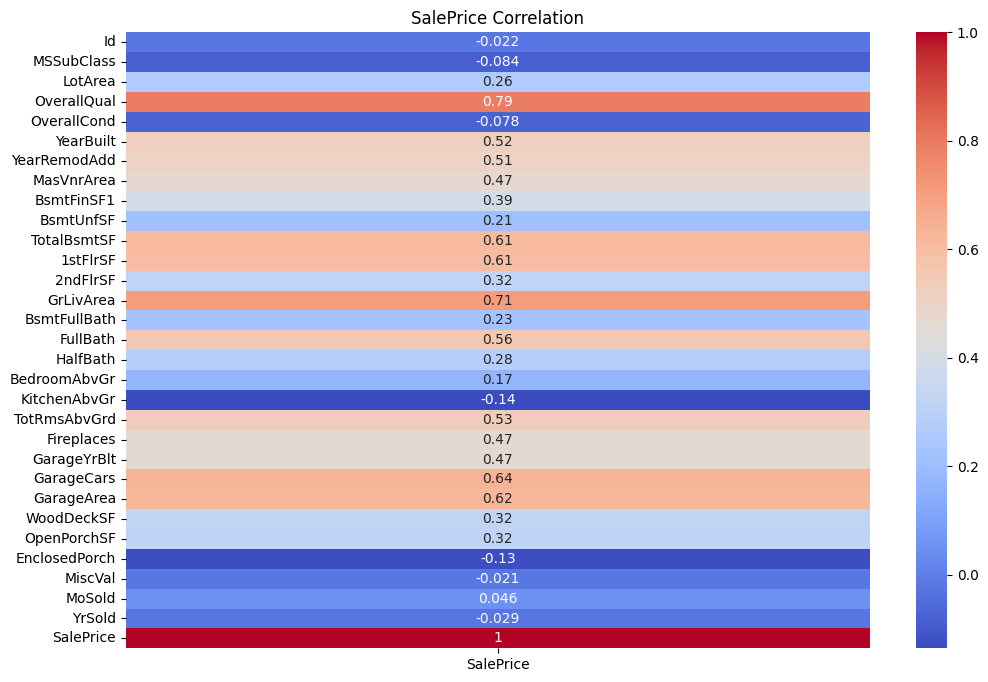

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot target feature correlation
plt.figure(figsize=(12, 8))
sns.heatmap(corr_X[['SalePrice']], annot=True, cmap='coolwarm')
plt.title('SalePrice Correlation')
plt.show()

In [19]:
# filter out unnecessary features columns
unnecessary_col = corr_Xtarget[abs(corr_Xtarget) < 0.1].index.tolist()
X = X.drop(columns=unnecessary_col)
X_test = X_test.drop(columns=unnecessary_col)
X

,LotArea,LotShape,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,...,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,SaleType,SaleCondition,SalePrice
0,8450.0,Reg,Inside,CollgCr,Norm,1Fam,2Story,7.0,2003.0,2003.0,...,2003.0,RFn,2.0,548.0,0.0,61.0,0.0,WD,Normal,208500.0
1,9600.0,Reg,FR2,Veenker,Feedr,1Fam,1Story,6.0,1976.0,1976.0,...,1976.0,RFn,2.0,460.0,298.0,0.0,0.0,WD,Normal,181500.0
2,11250.0,IR1,Inside,CollgCr,Norm,1Fam,2Story,7.0,2001.0,2002.0,...,2001.0,RFn,2.0,608.0,0.0,42.0,0.0,WD,Normal,223500.0
3,9550.0,IR1,Corner,Crawfor,Norm,1Fam,2Story,7.0,1915.0,1970.0,...,1998.0,Unf,3.0,642.0,0.0,35.0,272.0,WD,Abnorml,140000.0
4,14260.0,IR1,FR2,NoRidge,Norm,1Fam,2Story,8.0,2000.0,2000.0,...,2000.0,RFn,3.0,836.0,192.0,84.0,0.0,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,7917.0,Reg,Inside,Gilbert,Norm,1Fam,2Story,6.0,1999.0,2000.0,...,1999.0,RFn,2.0,460.0,0.0,40.0,0.0,WD,Normal,175000.0
1456,13175.0,Reg,Inside,NWAmes,Norm,1Fam,1Story,6.0,1978.0,1988.0,...,1978.0,Unf,2.0,500.0,349.0,0.0,0.0,WD,Normal,210000.0
1457,9042.0,Reg,Inside,Crawfor,Norm,1Fam,2Story,7.0,1941.0,2006.0,...,1941.0,RFn,1.0,252.0,0.0,60.0,0.0,WD,Normal,266500.0
1458,9717.0,Reg,Inside,NAmes,Norm,1Fam,1Story,5.0,1950.0,1996.0,...,1950.0,Unf,1.0,240.0,366.0,0.0,112.0,WD,Normal,142125.0


# Data Preprocessing (Data Transformation)

In [20]:
# overview dataset again to remove unnecessary features
X

,LotArea,LotShape,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,...,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,SaleType,SaleCondition,SalePrice
0,8450.0,Reg,Inside,CollgCr,Norm,1Fam,2Story,7.0,2003.0,2003.0,...,2003.0,RFn,2.0,548.0,0.0,61.0,0.0,WD,Normal,208500.0
1,9600.0,Reg,FR2,Veenker,Feedr,1Fam,1Story,6.0,1976.0,1976.0,...,1976.0,RFn,2.0,460.0,298.0,0.0,0.0,WD,Normal,181500.0
2,11250.0,IR1,Inside,CollgCr,Norm,1Fam,2Story,7.0,2001.0,2002.0,...,2001.0,RFn,2.0,608.0,0.0,42.0,0.0,WD,Normal,223500.0
3,9550.0,IR1,Corner,Crawfor,Norm,1Fam,2Story,7.0,1915.0,1970.0,...,1998.0,Unf,3.0,642.0,0.0,35.0,272.0,WD,Abnorml,140000.0
4,14260.0,IR1,FR2,NoRidge,Norm,1Fam,2Story,8.0,2000.0,2000.0,...,2000.0,RFn,3.0,836.0,192.0,84.0,0.0,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,7917.0,Reg,Inside,Gilbert,Norm,1Fam,2Story,6.0,1999.0,2000.0,...,1999.0,RFn,2.0,460.0,0.0,40.0,0.0,WD,Normal,175000.0
1456,13175.0,Reg,Inside,NWAmes,Norm,1Fam,1Story,6.0,1978.0,1988.0,...,1978.0,Unf,2.0,500.0,349.0,0.0,0.0,WD,Normal,210000.0
1457,9042.0,Reg,Inside,Crawfor,Norm,1Fam,2Story,7.0,1941.0,2006.0,...,1941.0,RFn,1.0,252.0,0.0,60.0,0.0,WD,Normal,266500.0
1458,9717.0,Reg,Inside,NAmes,Norm,1Fam,1Story,5.0,1950.0,1996.0,...,1950.0,Unf,1.0,240.0,366.0,0.0,112.0,WD,Normal,142125.0


In [21]:
import numpy as np

# separate the target feature and reduce its skewness
y = X['SalePrice']
X = X.drop(columns=['SalePrice'])
y = np.log1p(y)
y

,SalePrice
0,12.247699
1,12.109016
2,12.317171
3,11.849405
4,12.429220
...,...
1455,12.072547
1456,12.254868
1457,12.493133
1458,11.864469


# Data Preprocessing (Data Scaling)

In [22]:
# check for the dataset its types
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 46 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotArea        1460 non-null   float64
 1   LotShape       1460 non-null   object 
 2   LotConfig      1460 non-null   object 
 3   Neighborhood   1460 non-null   object 
 4   Condition1     1460 non-null   object 
 5   BldgType       1460 non-null   object 
 6   HouseStyle     1460 non-null   object 
 7   OverallQual    1460 non-null   float64
 8   YearBuilt      1460 non-null   float64
 9   YearRemodAdd   1460 non-null   float64
 10  RoofStyle      1460 non-null   object 
 11  Exterior1st    1460 non-null   object 
 12  MasVnrArea     1460 non-null   float64
 13  ExterQual      1460 non-null   object 
 14  Foundation     1460 non-null   object 
 15  BsmtQual       1460 non-null   object 
 16  BsmtExposure   1460 non-null   object 
 17  BsmtFinType1   1460 non-null   object 
 18  BsmtFinS

In [23]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# identify numeric and categorical features
numFT_X = X.select_dtypes(include=['int64', 'float64']).columns
catFT_X = X.select_dtypes(exclude=['int64', 'float64']).columns

# pipeline for data scaling
scaling = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numFT_X),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), catFT_X)
    ]
)

# Data Splitting

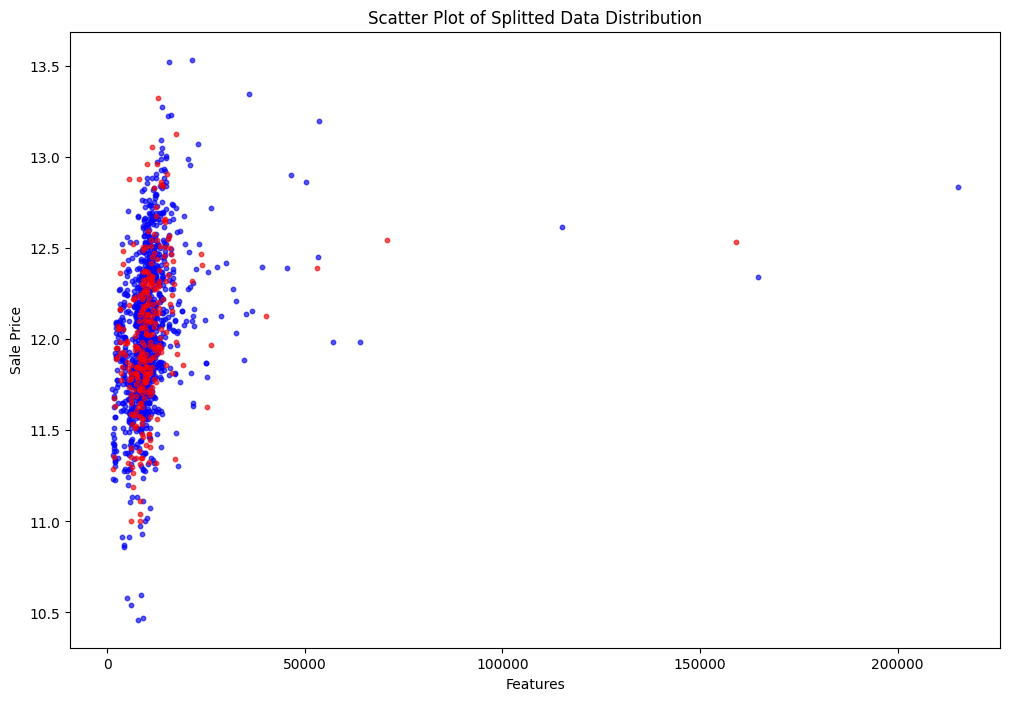

In [24]:
from sklearn.model_selection import train_test_split

# let's split the dataset 80% training and 20% validation
bins = pd.cut(y, bins=5, labels=False)
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.80, random_state=42, stratify=bins)

# plot splitted data
plt.figure(figsize=(12, 8))
plt.scatter(X.iloc[:,0], y, color='gray', alpha=0.2, label='Original Data', s=10)
plt.scatter(X_train.iloc[:,0], y_train, color='blue', alpha=0.6, label='Training Data', s=10)
plt.scatter(X_val.iloc[:,0], y_val, color='red', alpha=0.6, label='Validation Data', s=10)

plt.title('Scatter Plot of Splitted Data Distribution')
plt.xlabel('Features')
plt.ylabel('Sale Price')
plt.show()

# Model Training

In [25]:
print(X.columns)

Index(['LotArea', 'LotShape', 'LotConfig', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'Exterior1st', 'MasVnrArea', 'ExterQual', 'Foundation',
       'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'SaleType', 'SaleCondition'],
      dtype='object')


In [26]:
from sklearn.linear_model import LinearRegression

# linear model pipeline
linear_pipeline = Pipeline(
    steps = [
        ('preprocessor', scaling),
        ('linear', LinearRegression())
    ]
)

# fit the data into the pipeline
linear_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCa...
                                                                sparse_output=False),
                                                  Index(['LotShape', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType',
       'HouseStyle', 'RoofStyle', 'Exterior1st', 'ExterQual', 'Foundation',
       'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
       'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish',
       'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('linear', LinearRegression())])

In [27]:
from sklearn.metrics import mean_squared_error

# predict fitted model
y_pred = linear_pipeline.predict(X_val)

# mean squared error from the dataset and predicted
mse = mean_squared_error(y_val, y_pred)

np.sqrt(mse)

0.1532610678392548

# Submission

In [28]:
test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"
test_data = pd.read_csv(test_file_path)
test_data['Id'] = test_data['Id'].astype(int)
ids = test_data.pop('Id')

test_pred = linear_pipeline.predict(X_test)

pd.DataFrame({
    'Id': ids,
    'SalePrice': np.exp(test_pred)
}).to_csv('/kaggle/working/submission.csv', index=False)